# Transfer Learning

Usar transfer learning para clasificar las imágenes en la carpeta datasets. Comparen los resultados
del modelo si se tiene en cuenta el mejor resultado o los mejores dos por predicción.

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

2024-05-24 11:38:22.732526: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-24 11:38:22.736613: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-24 11:38:22.780946: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-24 11:38:23.577161: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

Cargar un set de entrenamiento y validación usando la función
image_dataset_from_directory de tensorflow.keras.preprocessing (asignar un tamaño a las
imágenes).

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory="./data/datasets",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE,
)

Found 333 files belonging to 5 classes.


2024-05-24 11:39:35.790187: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-24 11:39:36.026775: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [19]:
class_names = dataset.class_names
n_classes = len(class_names)
print(class_names)

['cats', 'chicken', 'dogs', 'hamster', 'horse']


2024-05-24 11:40:08.333030: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 46949655 exceeds 10% of free system memory.
2024-05-24 11:40:08.535625: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 59885568 exceeds 10% of free system memory.
2024-05-24 11:40:08.723269: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 43827840 exceeds 10% of free system memory.
2024-05-24 11:40:08.788477: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 46080000 exceeds 10% of free system memory.
2024-05-24 11:40:08.808786: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 47941632 exceeds 10% of free system memory.
2024-05-24 11:40:10.843467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


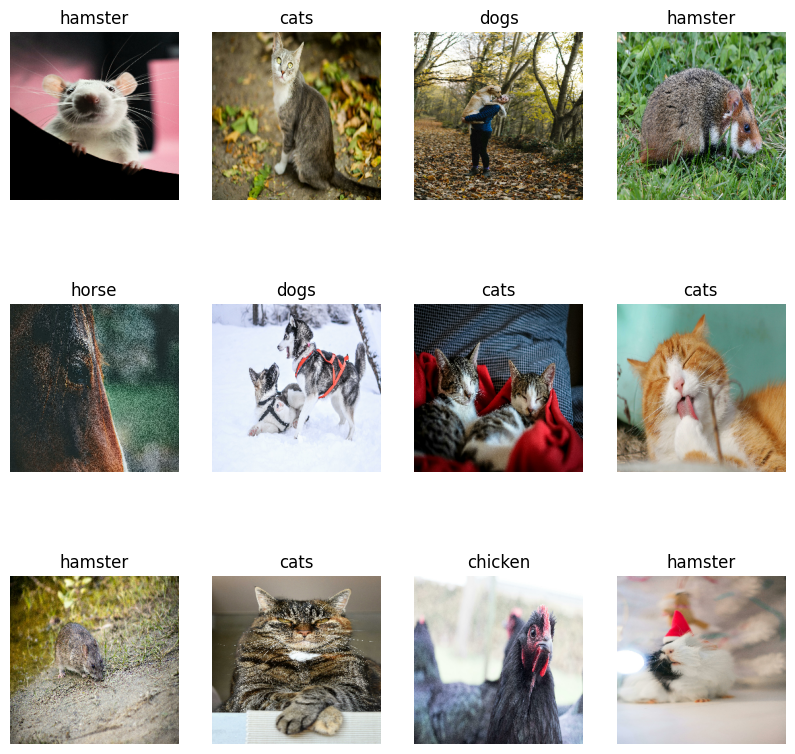

In [10]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [11]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.2,  shuffle=True, shuffle_size=10000):
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(len(ds) * train_split)
    val_size = int(len(ds) * val_split)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    return train_ds, val_ds

In [13]:

train_ds, val_ds = get_dataset_partitions_tf(dataset)

In [14]:

len(train_ds), len(val_ds)

(8, 2)

In [15]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [16]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

In [17]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [18]:
# Load the InceptionV3 model
inception = tf.keras.applications.InceptionV3(
    input_shape = (IMAGE_SIZE,IMAGE_SIZE,CHANNELS),
    include_top=False, 
    weights='imagenet')
# Freeze the pre-trained model weights
inception.trainable = False

In [ ]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    inception,
    tf.keras.layers.GlobalAveragePooling2D(), #GlobalAveragePooling2D layer
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dropout(rate=0.2), #Dropout layer
    tf.keras.layers.Dense(240,activation='relu'), # Dense layer
    tf.keras.layers.Dropout(rate=0.1), #Dropout layer
    tf.keras.layers.Dense(240,activation = 'relu'), # Dense layer
    tf.keras.layers.Dropout(rate=0), #Dropout layer
    tf.keras.layers.Dense(120,activation = 'softmax')
])